# Quick Start

## When first time import ``LOTUS``

In [1]:
import lotus_nlte
lotus_nlte.utils.docs_setup()
print(f"lotus_nlte.__version__ = '{lotus_nlte.__version__}'")

lotus_nlte.__version__ = '0.1.1rc3.dev4+g68c6449.d20211211'


When you first import ``lotus_nlte``, it will download interpolated models for each line in our "golden linelist" with their calculated precision at certain grid points. Once they have been downloaded in your disk, it will be no longer downloaded again for your next run. ``docs_setup()`` mainly collect some warnings created by theano and set up our matplotlib style. This process always costs around 5 mins. You can access the directory of your interpolated models at ``lotus_nlte.config.GCOGDIR`` and the directory of calculated precision files at ``lotus_nlte.config.EWDIFFDIR``:

In [2]:
print(f"Interpolated General Curve of Growth direcory:'{lotus_nlte.config.GCOG_DIR}'")
print(f"Interpolated EW precision direcory:'{lotus_nlte.config.EWDIFF_DIR}'")

Interpolated General Curve of Growth direcory:'/media/yangyangli/OS/yangyangli_private/Code/NLTE/LOTUS-dev/src/lotus_nlte/package_data/gcoglib/'
Interpolated EW precision direcory:'/media/yangyangli/OS/yangyangli_private/Code/NLTE/LOTUS-dev/src/lotus_nlte/package_data/ewdiff/'


We also provide a line list from [Jofre et al. (2014)](https://www.aanda.org/articles/aa/abs/2014/04/aa22440-13/aa22440-13.html) and [Heiter et al. (2015)](https://www.aanda.org/articles/aa/abs/2015/10/aa26319-15/aa26319-15.html). You can check which lines are included in this linelist:

In [3]:
import pandas as pd
import os
fp = os.path.dirname(os.path.realpath(lotus_nlte.__file__))
obs_path = fp + "/package_data/linelist/final.linelist"
linelist = pd.read_csv(obs_path)
linelist.head()#showing first 5 lines

,Line,lambda,Ex.P
0,FeI,3440.61,0.00
1,FeI,3440.99,0.05
2,FeI,3447.28,2.20
3,FeI,3450.33,2.22
4,FeI,3451.91,2.22


## Interpolate stellar metalicity [Fe/H]

You must specify your line information, which region you want to interpolate the abundance via ``stellar_type`` and the type of calculation assumption via ``cal``. Notice that you must set ``interpolated=True`` in ``SingleGCOG``. ``stellar_type="whole grid"`` uses the whole grid: $4000 K \leqslant \mathrm{T}_\mathrm{eff} \leqslant 6850 K$, $0.0 \leqslant \mathrm{log}\mathit{g} \leqslant 5.0$ and $0.5 km\cdot s^{-1} \leqslant \xi_t \leqslant 3.0 km\cdot s^{-1}$. Other options for this argument can be in the following format: ``spectral type/mass type/metalicity type``. For example, if your star is a metal rich G dwarf, you can set ``stellar_type="G/dwarf/metal_rich"``. We provide categories of each stellar type and their corresponding ranges of stellar parameters in the following chart:

| Categories | Options | Parameter ranges |
| --- | --- | --- |
|Spectral Type(Teff)| K | [4000, 5200) |
|              | G | [5200, 6000) |
|              | F | [6000, 6850] |
|   Mass Type(logg)  |supergiant| [0.0, 0.5) |
|                    |   giant  | [0.5, 3.0) |
|                    | subgiant | [3.0, 4.0) |
|                    |   dwarf  | [4.0, 5.0] |
|  Metalicity Type([Fe/H])  | very_metal_poor | [-3.5, -2.0) |
|                    |    metal_poor   | [-2.0, -0.5) |
|                    |    metal_rich   | [-0.5, 0.5)  |

If you have estimated the ranges of your stellar parameters, you can pick any options in the above chart and combine them as the final value of ``stellar_type``.

In [4]:
from lotus_nlte.gcogs.gcog import SingleGCOG
wavelength = 5307.36
excitation_potential = 1.61
element = "FeI"
sg_nlte = SingleGCOG(wavelength, excitation_potential, element, stellar_type="whole_grid", cal="nlte", interpolated=True)
model_nlte = sg_nlte.load_model()

In [5]:
teff = 5200
logg = 2.5
vt = 1.5
ew = 80
#predict the interpolated metalicity, the reference solar [Fe/H] is 7.46
model_nlte.predict([[teff, logg, vt, ew]])

array([-0.82065384])

You can also obtain Non-LTE correction of metalicity by call another model using ``cal="lte"``:

In [6]:
sg_lte = SingleGCOG(wavelength, excitation_potential, element, stellar_type="whole_grid", cal="lte", interpolated=True)
model_lte = sg_lte.load_model()
correction = model_nlte.predict([[teff, logg, vt, ew]]) - model_lte.predict([[teff, logg, vt, ew]])
correction

array([0.14367426])

## Plot interpolated specific Curve of Growth (COG) fixing $\mathrm{T}_\mathrm{eff}$, $\mathrm{log}\mathit{g}$ and $\xi_t$

This can be done by fixing $\mathrm{T}_\mathrm{eff}$, $\mathrm{log}\mathit{g}$ and $\xi_t$ in the GCOG, the default range of EWs is from 1 $m\overset{\circ}A$ to 100$m\overset{\circ}A$. You can define your EWs via ``ews`` in method function ``plot_interpolated_cog``:

<IPython.core.display.Javascript object>


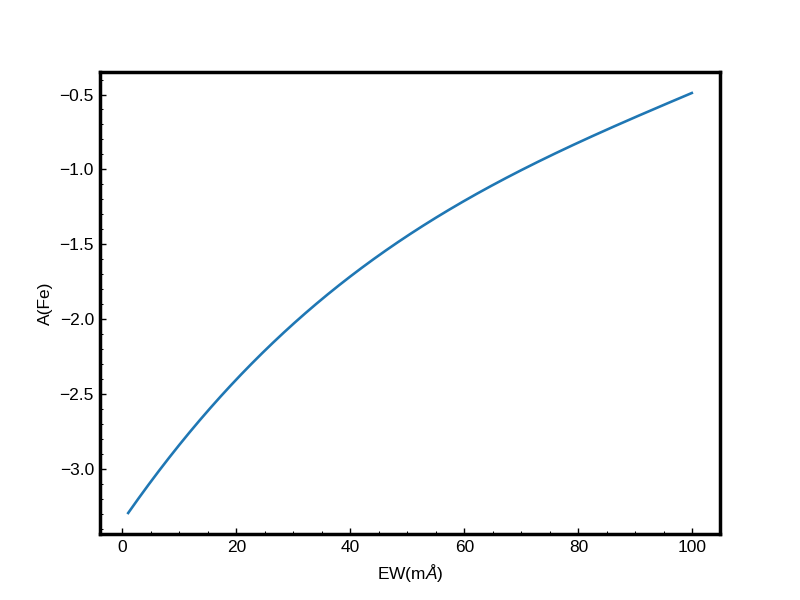

In [7]:
%matplotlib notebook
fig = sg_nlte.plot_interpolated_cog(teff, logg, vt)

## Derive stellar parameters via minimization of ionization and exciation balance

We choose observed EWs from Sun to illustrate how ``LOTUS`` obtain the optimal stellar parameters. Calculation assumption is LTE:

In [8]:
import os
fp = os.path.dirname(os.path.realpath(lotus_nlte.__file__))
obs_path = fp + "/test/data/Sun.csv"

The format of your observed EW list should contain the following columns at least, you can check our sample data from the above ``Sun.csv`` as a reference:

|obs_wavelength|element |obs_ew |obs_ep|
|---|---|---|---|

``PolyMultiGCOG`` include all lines into the class and access their corresponding interpolated genenral curve of growth (GCOG) according the stellar_type ``stellar_type``, adopted excitation potential cutoff ``exp_cutoff``, calculation assumption ``cal`` and estimation precision which is homogeous for every lines (you can set it via ``ew_error``, default value is 5$m\overset{\circ}A$). Method ``pipelines`` determines which lines are trustful for later determination of stellar parameters.

Excitation potential cutoff has been adopted by [Bergemann et al. (2012)](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1365-2966.2012.21687.x) and [Roederer et al. (2018)](https://iopscience.iop.org/article/10.3847/1538-4357/aac6df) to obtain consisten stellar parameters from EW method and achieve ioinisaztion equilibria and excitation equilibria under the optimal stellar parameters. We recommend users to set this argument when not reaching best optimization. For ``metal_rich`` star, we recommend ``exp_cutoff=0``; For ``metal_poor`` star,  recommended ``exp_cutoff`` is 1.2; For ``very_metal_poor`` star, we recommend ``exp_cutoff`` as 2.0 or 2.7.

In [9]:
from lotus_nlte.gcogs.multigcogs import PolyMultiGCOG
star = "Sun"
stellar_type = "G/dwarf/metal_rich"
exp_cutoff = 0 #excitation potential cutoff, here for metal rich star we don't need to add any cutoff
cal = "lte"
mgcog = PolyMultiGCOG(star=star, stellar_type=stellar_type, exp_cutoff=exp_cutoff, 
                      obs_path=obs_path,cal=cal)
mgcog.pipelines()

All optimizations are based on exist interpolated models and you don't need to interpolate them!
Hypersurface of line 4787.83A with ep=3.00ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4788.76A with ep=3.24ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4789.65A with ep=3.55ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4793.96A with ep=3.05ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4794.35A with ep=2.42ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4802.88A with ep=3.64ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4808.15A with ep=3.25ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4869.46A with ep=3.55ev of element FeI has already existed and passes test of interpolation

Hypersurface of line 5618.63A with ep=4.21ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5619.60A with ep=4.39ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5633.95A with ep=4.99ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5636.70A with ep=3.64ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5638.26A with ep=4.22ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5641.43A with ep=4.26ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5649.99A with ep=5.10ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5651.47A with ep=4.47ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 5652.32A with ep=4.26ev of element FeI has already existed and passes test 

Hypersurface of line 6750.15A with ep=2.42ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 6752.71A with ep=4.64ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 6786.86A with ep=4.19ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 6804.27A with ep=4.58ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 6810.26A with ep=4.61ev of element FeI has already existed and passes test of interpolation
Hypersurface of line 4993.35A with ep=2.81ev of element FeII has already existed and passes test of interpolation
Hypersurface of line 5256.93A with ep=2.89ev of element FeII has already existed and passes test of interpolation
Hypersurface of line 5264.80A with ep=3.23ev of element FeII has already existed and passes test of interpolation
Hypersurface of line 5325.55A with ep=3.22ev of element FeII has already existed and passes t

Start optimization using __differential evolution algorithm__, a required parameter is ``bound``, which is the constraints of $\mathrm{T}_\mathrm{eff}$, $\mathrm{log}\mathit{g}$ and $\xi_t$ during optimization. You can either use our tools from ``utils`` to access this according to your stellar type or define this yourself. Notice that the bound should be within the boundary of current grid: $4000 K \leqslant \mathrm{T}_\mathrm{eff} \leqslant 6850 K$, $0.0 \leqslant \mathrm{log}\mathit{g} \leqslant 5.0$ and $0.5 km\cdot s^{-1} \leqslant \xi_t \leqslant 3.0 km\cdot s^{-1}$:

In [10]:
from lotus_nlte.optimize import DiffEvoStellarOptimization
from lotus_nlte.utils import generate_ranges

``physicaltol``array contains the convergence conditions for the absolute values of the slope of fitted line given by the derived abundances and exicitation potential of all lines, the slope from the derived abundances and reduced equivalent widths of all lines and the difference of the average abundance from FeI and FeII lines; ``disp``, ``popsize``, ``recombination``, ``mutation`` are parameters from ``scipy.optimize.differential_evolution``, details can be check in [differential_evolution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html). **We suggest users to use values belows for good performance**:

In [11]:
bounds = [tuple(r) for r in generate_ranges(stellar_type)[:2]]
bounds.append((0.5, 3.0))
de = DiffEvoStellarOptimization(mgcog, bounds, physicaltol=[1e-5,2e-5,5e-5])
result = de.optimize(disp=True, popsize=100, recombination=0.3, mutation=(0.8,1.2))

differential_evolution step 1: f(x)= 9.38766
differential_evolution step 2: f(x)= 7.7971
differential_evolution step 3: f(x)= 7.7971
differential_evolution step 4: f(x)= 5.67808
differential_evolution step 5: f(x)= 4.28423
differential_evolution step 6: f(x)= 4.28423
differential_evolution step 7: f(x)= 1.29133
differential_evolution step 8: f(x)= 1.29133
differential_evolution step 9: f(x)= 1.29133
differential_evolution step 10: f(x)= 1.29133
differential_evolution step 11: f(x)= 1.29133
differential_evolution step 12: f(x)= 1.29133
differential_evolution step 13: f(x)= 0.395751
differential_evolution step 14: f(x)= 0.395751
differential_evolution step 15: f(x)= 0.395751
differential_evolution step 16: f(x)= 0.395751
differential_evolution step 17: f(x)= 0.395751
differential_evolution step 18: f(x)= 0.395751
differential_evolution step 19: f(x)= 0.301614
differential_evolution step 20: f(x)= 0.301614
differential_evolution step 21: f(x)= 0.301614
differential_evolution step 22: f(x)

Final optimal results can be check with the output from ``optimize()``, a dictionary named ``stellarpars`` contains your stellar parameters and their roughly estimated uncertainty:

In [12]:
result['stellarpars']

{'Teff': [5712.097257814576, 28.295096855057864],
 'logg': [4.3461948165328925, 0.05148673428035967],
 'feh': [-0.13347877062286426, 0.10335153537220176],
 'Vmic': [0.7769916663894697, 0.030948064231603387]}

We can plot the final equilibria fixed at such stellar parameter combination by ``plot_optimized_equilibrium``:

<IPython.core.display.Javascript object>


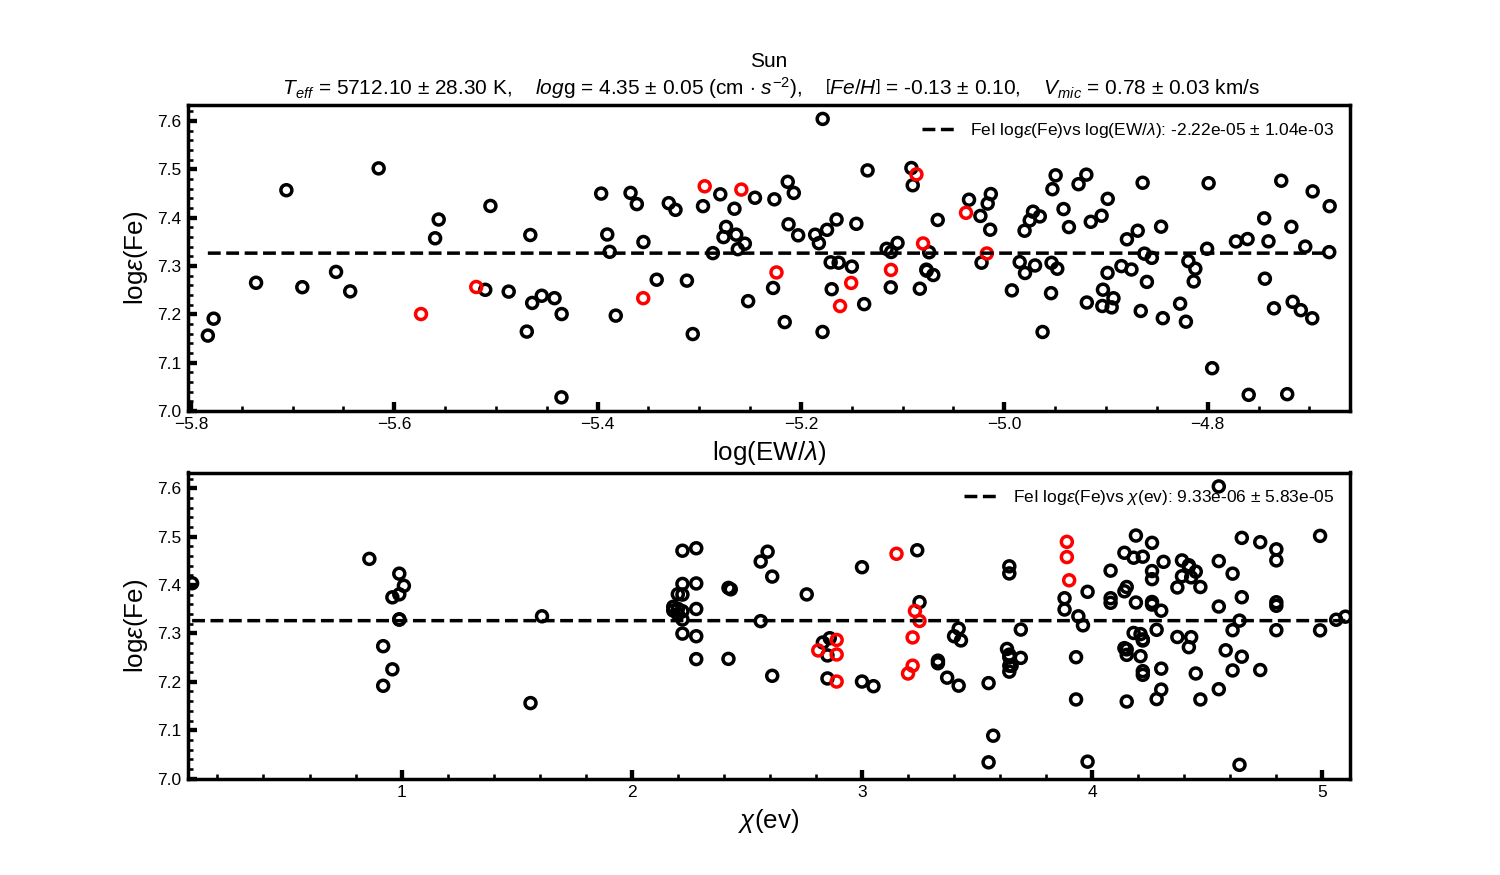

In [13]:
%matplotlib notebook
from lotus_nlte.plot import plot_optimized_equilibrium
import numpy as np
idx_fei = np.where(np.array(mgcog.obs_ele) =="FeI")
idx_feii = np.where(np.array(mgcog.obs_ele) =="FeII")
REWs = np.log10(1e-3*np.array(mgcog.obs_ew)/np.array(mgcog.obs_wavelength))
chis = np.array(mgcog.obs_ep)
fit_pars = [result['dAdREW'], result['dAdchi']]
abunds = de.abunds

fig = plot_optimized_equilibrium("Sun", result['stellarpars'], fit_pars, REWs1=REWs[idx_fei], REWs2=REWs[idx_feii],
                                chis1=chis[idx_fei], chis2=chis[idx_feii], abunds1=abunds[idx_fei],
                                abunds2=abunds[idx_feii])

If you want to conduct a thorough analysis of your star and perform [MCMC](https://en.wikipedia.org/wiki/Slice_sampling) to obtain well-contrained uncertainty of each derived stellar parameters, please go to
[Example](./examples.ipynb) and get an example fitting a star in 'real' observations.